In [1]:
#from maze_library import shortest_path, read_maze
%load_ext autoreload
%autoreload 2
%run maze_library.ipynb
from matplotlib import pyplot as plt

In [2]:
maze, graph, P = read_maze('maze_test.ascii', test=True)
print(P)
print(maze)

{'S': P{(6,0),  42}, 'G': P{(6,6),  48}, 'B': [P{(4,2),  30}], 'R': [P{(2,4),  18}]}
[[1 1 1 1 1 1 1]
 [1 0 1 0 1 0 1]
 [1 1 1 1 1 1 1]
 [1 0 1 0 1 0 1]
 [1 1 1 1 1 1 1]
 [1 0 1 0 1 0 1]
 [1 0 1 1 1 1 1]
 [1 0 0 0 0 0 0]]


In [3]:
# 1.
pos_curr = P['S']
pos_last = pos_curr

# 2.
path = shortest_path(graph, pos_curr, G, verbose=True)

# For debug plotting below
path_taken = [P['S']]
P_orig = deepcopy(P)
maze_orig = deepcopy(maze)
distances_total = []
    
while pos_curr != P['G']:
    
    print('\n')
    # 3
    pos_next = path.pop(0)
    path_taken.append(pos_next)
    
    follow_edge(pos_last, pos_curr, pos_next, verbose=True)

    pos_last = pos_curr
    pos_curr = pos_next
#     pos_next = path.pop(0)

    # None / B / R: Kein Block / Blau / Rot
    block_status = robot_identify_block(pos_curr, P, verbose=True)
    
    # Kein Block
    if block_status is None:
        pass

    elif block_status == 'B':
        graph, maze = delete_adj_edges(graph, pos_last, pos_curr, maze, verbose=True)
        path = shortest_path(graph, pos_curr, G, verbose=True)

    elif block_status == 'R':
        neighbours = find_neighbours(graph, pos_curr, verbose=True)
        candidates = []
                
        # Find opposite nodes
        if len(neighbours) == 2:
            
            if points_on_straight_line( *neighbours ):
                candidates = [ tuple(neighbours) ]
            # Block is not movable
            else:
                graph, maze = delete_adj_edges(graph, pos_last, pos_curr, maze, verbose=True)
                path = shortest_path(graph, pos_curr, G, verbose=True)
                
        if len(neighbours) == 3:
        
            for p in neighbours[1:]:
                if points_on_straight_line(neighbours[0], p):
                    candidates = [ (neighbours[0], p) ]
                    
            if candidates == []:
                candidates = [ tuple(*neighbours[1:]) ]
                
        if len(neighbours) == 4:
            
            for ppp, p in enumerate(neighbours[1:]):
                
                if points_on_straight_line(neighbours[0], p):
                    candidates.append( (neighbours[0], p) )
                    candidates.append( tuple([ n for nnn, n in enumerate(neighbours[1:]) if nnn != ppp ]) )
                    print('Found opposite node pair:', candidates[-2], candidates[-1])
                    break
                    
        distances = []
        # E.g: c = (neighbours[0], p) 
        for c in candidates:
            
            # Delete blocked edges temporary
            graph_tmp, _ = delete_adj_edges(deepcopy(graph), pos_last, pos_curr, verbose=True)
            
            for iii in range(2):

                # From pos_curr to push position
                try:
                    print('\nPushing from {} to {}'.format(*c))
                    # Find path to start pushing
                    # .. skipt if start pushing position is pos_last
                    if pos_last == c[iii]:
                        path = []
                    else:
                        path = shortest_path(graph_tmp, pos_curr, c[iii], verbose=True)
                    # Push and go back
                    path += [ pos_curr, c[(iii+1)%2], pos_curr ]
                    # Walk the rest
                    path += shortest_path(graph, pos_curr, G, verbose=True)
                    print(path)
                    
                    distances.append( [(c[iii], c[(iii+1)%2]), len(path)-1, path, pos_last] )
                    
                # Disqualify path if no connection exists
                except nx.NetworkXNoPath:
                    pass
                
            # No pushing at all
            try:
                path = shortest_path(graph_tmp, pos_curr, G, verbose=True)
                # None is placeholder for not pushing at all / it's best not to push
                distances.append( [None, len(path)-1, path, pos_last] )
            except nx.NetworkXNoPath:
                    pass
        
        # Sort for distances / find shortest path
        distances = sorted(distances, key=lambda x: x[1])
        
        # Verbose debugging output
        # TODO: Remove after debugging
        for d in distances:
            if d[0] is not None:
                print('\n {} steps for push from {} to {},\npath: {}'.format(d[1], *d[0], d[2]))
            else:
                print('\n {} steps for not pushing,\npath: {}'.format(d[1], d[2]))
        
        # Take shortest path / best solution
        tmp_pos_pair, tmp_N, path, pos_last = distances[0]
        
        # TODO: Remove after debugging
        distances_total.append(distances)
        # If pushing ...
        if tmp_pos_pair is not None:
            # Update position R
            P['R']  = [ tmp_pos_pair[1] if x == pos_curr else x for x in P['R'] ]
            print('Updated P[R]:', P['R'])
            print('\nDecided to push the red block from {} to {}.'.format(*tmp_pos_pair))
        else:
            print('\nDecided not to push')
        print('Total steps to path: {}', tmp_N)
        print('Decided path to go:', path)

print('D O N E !')

Found SP (from P{(6,0),  42} -> P{(6,6),  48}): [P{(5,0),  35}, P{(4,0),  28}, P{(4,1),  29}, P{(4,2),  30}, P{(4,3),  31}, P{(4,4),  32}, P{(4,5),  33}, P{(4,6),  34}, P{(5,6),  41}, P{(6,6),  48}]


===> Going from P{(6,0),  42} to P{(5,0),  35}.
No block found at P{(5,0),  35}


===> Going from P{(5,0),  35} to P{(4,0),  28}.
No block found at P{(4,0),  28}


===> Going from P{(4,0),  28} to P{(4,1),  29}.
No block found at P{(4,1),  29}


===> Going from P{(4,1),  29} to P{(4,2),  30}.
Found B at P{(4,2),  30}
Remove from graph all adj. nodes of P{(4,2),  30} but P{(4,1),  29}
Removing from maze: P{(3,2),  23}
Removing from maze: P{(5,2),  37}
Removing from maze: P{(4,3),  31}
Removing from graph edge: (30,23)
Removing from graph edge: (30,31)
Removing from graph edge: (30,37)
Found SP (from P{(4,2),  30} -> P{(6,6),  48}): [P{(4,1),  29}, P{(4,0),  28}, P{(3,0),  21}, P{(2,0),  14}, P{(2,1),  15}, P{(2,2),  16}, P{(2,3),  17}, P{(2,4),  18}, P{(2,5),  19}, P{(2,6),  20}, P{(3,6), 

In [4]:
path_taken = [ p.unravel for p in path_taken ]

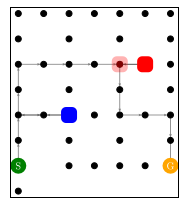

In [7]:
from matplotlib import transforms
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

fig, ax = plt.subplots(figsize=(3,3.5))

def transform(x,y):
    return y, -x

# Plot maze
ax.scatter(*transform(*np.where(maze_orig==1)), color='black')
ax.set_xticks([]), ax.set_yticks([])
ax.axis('equal')

def plot_block(position, label, color, ax=ax, alpha=1, marker='o'):
    ax.scatter(*transform(*position.unravel), linewidths=10, color=color, alpha=alpha, marker=marker)
    ax.text(*transform(*position.unravel), label, color='white', ha='center', va='center')
    
# # .. path
x, y = transform(*np.array(list(zip(*path_taken))))
ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1.1, width=.005, alpha=.5)

# # .. Start and Goal
plot_block(P['S'], 'S', 'green')

plot_block(P['G'], 'G', 'orange')

# .. original red block positions
for p in P_orig['R']:
    plot_block(p, '', 'red', alpha=.3, marker='s')

# .. current red block positions
for p in P['R']:
    plot_block(p, '', 'red', marker='s')

# .. current blue block positions
for p in P['B']:
    plot_block(p, '', 'blue', marker='s')

# plt.show()
fig.savefig('algorithm_complete.pgf')

In [227]:
options_red = distances_total[0]
# Double entry
options_red.pop(1)

[None,
 13,
 [P{(2,3),  17},
  P{(2,2),  16},
  P{(1,2),   9},
  P{(0,2),   2},
  P{(0,3),   3},
  P{(0,4),   4},
  P{(0,5),   5},
  P{(0,6),   6},
  P{(1,6),  13},
  P{(2,6),  20},
  P{(3,6),  27},
  P{(4,6),  34},
  P{(5,6),  41},
  P{(6,6),  48}],
 P{(2,3),  17}]

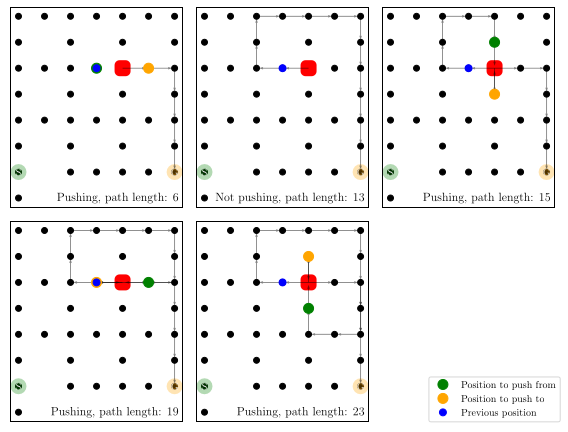

In [230]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(7.9, 6.1))

# Plot maze
for ii, case in enumerate(options_red):
    
    legend = {}
    path = [ p.unravel for p in case[2] ]
    if not path[0] == (2,4):
        path = [ (2,4) ] + path

    
    ax[ii//3, ii%3].scatter(*transform(*np.where(maze_orig==1)), color='black')
    
    # # .. Start and Goal
    plot_block(P['S'], 'S', 'green',  ax=ax[ii//3, ii%3], alpha=.3)
    plot_block(P['G'], 'G', 'orange', ax=ax[ii//3, ii%3], alpha=.3)
    
    ax[ii//3, ii%3].set_xticks([]), ax[ii//3, ii%3].set_yticks([])
    ax[ii//3, ii%3].axis('equal')
    ax[ii//3, ii%3].set_title(
        'Not pushing, path length: {} '.format(len(case[2])-1) if case[0] is None 
        else 'Pushing, path length: {} '.format(len(case[2])-1), y=.0, loc='right')
    
#     print(ii, '{:>17}'.format('None' if case[0] is None else str([ p.unravel for p in case[0] ])), [ p.unravel for p in case[2] ])

    # Plot red block
    plot_block(P_orig['R'][0], '', 'red', ax=ax[ii//3, ii%3], marker='s')

    # Rotate path
    x, y = transform(*np.array(list(zip(*path))))

    # Plot path
    ax[ii//3, ii%3].quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1.1, width=.005, alpha=.5)
    
    if case[0] is not None:
        for jj, p in enumerate( [ p.unravel for p in case[0] ] ):
            legend[jj], = ax[ii//3, ii%3].plot(*transform(*p), 'o', ms=10, color=['green', 'orange'][jj], label='Position to push from' if jj == 0 else 'Position to push to')
    
    legend['last'], = ax[ii//3, ii%3].plot(*transform(*case[3].unravel), 'o', ms=7, color='blue', label='Previous position')
    
fig.legend(handles=legend.values(), loc='lower right', bbox_to_anchor=(0.5, .02, 0.5, 0.5))

fig.delaxes(ax[1,2])
fig.tight_layout()
# fig.savefig('pushing_options.pgf')